Importing/Installing the Necessary Libraries
---

In [1]:
!pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283850 sha256=3c43be1d50fdeabac34d236de8cad6834589d0c7c591479911ced69221e4123c
  Stored in directory: c:\users\arman\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [2]:
!pip install opencv-python

In [4]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import cv2
from tensorflow import keras
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import seaborn as sns
import random
import bottleneck as bn
from sklearn.metrics import accuracy_score

Loading the Model
---

In [5]:
model = load_model('mnist.h5')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Classifier Function
---

In [7]:
def prepare_img(filepath):
    img_name = filepath.split('/')[-1]
    im = np.array(Image.open(filepath).convert('L'))
    im = cv2.resize(im, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    im = gray2rgb(im.reshape(28,28))
    return im

In [8]:
def classify_img(model, img):
    img = img.reshape((1,img.shape[0],img.shape[1],3))
    img = img.astype("float32") / 255
    pred = model(img)[0]
    class_idx = np.argmax(pred)
    return class_idx

Data Preparation
---

In [11]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 3)
x_train = gray2rgb(x_train.reshape(x_train.shape[0],28,28))
x_test = gray2rgb(x_test.reshape(x_test.shape[0],28,28))

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 7s 1us/step
x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


LIME
---

In [12]:
def get_heatmap(img, model):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img, model.predict)
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    return heatmap

In [13]:
# the following function gets the top n elements (in terms of magnitude) from a numpy array
def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

In [14]:
# given a list of tuples (pixel indices), this function generates a list of other pixels
def get_other_pixels(idx_list):
    idx_list = set(idx_list)
    other_pixels = []
    for i in range(28):
        for j in range(28):
            if (i,j) not in idx_list:
                other_pixels.append((i,j))
    return other_pixels

In [15]:
# given an image and a heatmap showing the importance of each pixels, this function destructs the image such that only a specified percentage of
# the most important pixels remains, and the other ones get replaced by salt and pepper noise
def destruct_image(img, heatmap, percentage=0.2):
    result = img.copy()
    idx_list = top_n_indexes(heatmap, int(percentage*(28*28)))
    idx_list.sort(key = lambda tup: tup[0])
    other_pixels = get_other_pixels(idx_list)
    for idx in other_pixels:
        # random_val = random.sample([0,1], 1)[0]
        random_val = 0
        result[idx[0],idx[1],0] = random_val
        result[idx[0],idx[1],1] = random_val
        result[idx[0],idx[1],2] = random_val
    return result

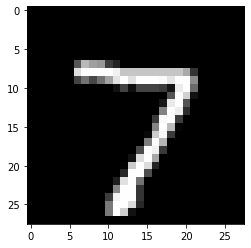

In [16]:
plt.imshow(x_test[0])

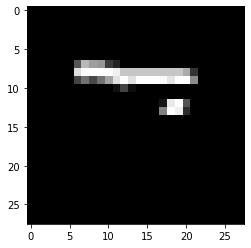

In [19]:
plt.imshow(destruct_image(x_test[0], get_heatmap(x_test[0].astype('double'), model), 0.2))

Image Desctruction: Adding Pepper Noise to the Images such that only 20 percent of the most important pixels of each one remains.
---

In [22]:
num_samples = 1000

In [23]:
new_x_test = []
for curr_img in x_test[:num_samples]:
    curr_heatmap = get_heatmap(curr_img.astype('double'), model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

In [24]:
new_predictions = model.predict(new_x_test)

In [25]:
new_predictions = list(np.argmax(new_predictions, axis=1))
true_labels = list(np.argmax(y_test[:num_samples], axis=1))

In [26]:
accuracy_score(true_labels, new_predictions)

0.416